#Importing Libraries


In [23]:
import tensorflow as tf
import numpy as np;
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Input, Dense, Activation
from tensorflow.keras.optimizers import SGD, Adam




In [24]:
if not os.path.isdir('models'):
    os.mkdir('models')





print('TensorFlow version: ', tf.__version__)
print('Is using GPU: ', tf.test.is_gpu_available())

TensorFlow version:  2.2.0
Is using GPU:  True


#Data Preprocessing

In [25]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2), indices_of(3)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [26]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(20000, 32, 32, 3) (20000, 4)
(4000, 32, 32, 3) (4000, 4)


#Visualzing the data

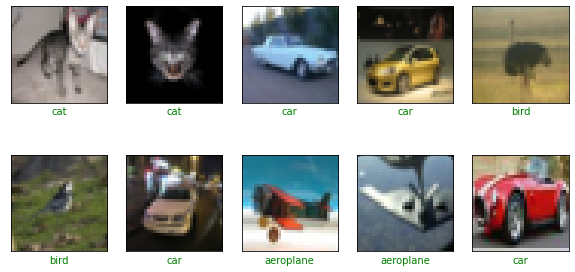

In [27]:
class_names = ['aeroplane', 'car', 'bird', 'cat']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_train, y_train, y_train)

In [28]:
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)
input_shape = (32, 32, 1)


print(x_test.shape[0], 'test samples')

x_valid,y_valid = x_train[:4000],y_train[:4000]
x_train,y_train = x_train[4000:],y_train[4000:]
print(x_train.shape[0], 'train samples')

print("x_train shape: ",x_train.shape)
print("x_valid shape: ",x_valid.shape)

4000 test samples
16000 train samples
x_train shape:  (16000, 32, 32, 3)
x_valid shape:  (4000, 32, 32, 3)


#Adding Image Augmentation

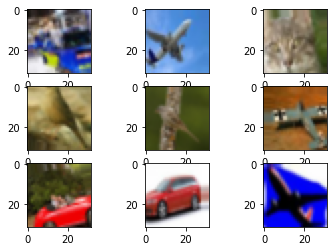

In [29]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    #zoom_range=0.3
    )
datagen.fit(x_train)


for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break




#Creating the model

In [38]:
from tensorflow.keras.regularizers import l2;
from tensorflow.keras.initializers import he_normal;


def create_model():
  model = tf.keras.models.Sequential();
  model.add(Input(shape = (32,32,3)))

  model.add(Conv2D(64, 3,padding = 'same'))
  model.add(Dropout(0))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(64, 3 ,padding = 'same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))


  model.add(Conv2D(128, 3, padding = 'same'))
  model.add(Dropout(0))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(128, 3, padding = 'same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))
  

  model.add(Conv2D(256, 3, padding = 'same'))
  model.add(Dropout(0))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Conv2D(256, 3, padding = 'same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=2))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(2044))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.4))

  model.add(Dense(2044))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.4))

  model.add(Dense(4, activation = 'softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam' , metrics=['accuracy'])

  return model

model = create_model()


model.summary()







Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
dropout_25 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_40 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_40 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_41 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_41 (Activation)   (None, 32, 32, 64)       

# Training the model

In [39]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=45),
                    epochs=25, validation_data=(x_valid, y_valid))
                   
        
                   
                   

  


Epoch 1/25
356/356 [==============================] - 9s 25ms/step - loss: 0.9850 - accuracy: 0.6424 - val_loss: 1.2213 - val_accuracy: 0.6140
Epoch 2/25
356/356 [==============================] - 9s 25ms/step - loss: 0.7321 - accuracy: 0.7188 - val_loss: 0.6577 - val_accuracy: 0.7585
Epoch 3/25
356/356 [==============================] - 9s 25ms/step - loss: 0.6020 - accuracy: 0.7645 - val_loss: 0.5635 - val_accuracy: 0.7868
Epoch 4/25
356/356 [==============================] - 9s 25ms/step - loss: 0.5235 - accuracy: 0.7951 - val_loss: 0.5163 - val_accuracy: 0.7940
Epoch 5/25
356/356 [==============================] - 9s 25ms/step - loss: 0.4819 - accuracy: 0.8167 - val_loss: 0.7917 - val_accuracy: 0.7545
Epoch 6/25
356/356 [==============================] - 9s 25ms/step - loss: 0.4441 - accuracy: 0.8327 - val_loss: 0.5644 - val_accuracy: 0.8055
Epoch 7/25
356/356 [==============================] - 9s 25ms/step - loss: 0.4071 - accuracy: 0.8452 - val_loss: 0.4662 - val_accuracy: 0.8317

# Results and predictions

{'loss': [0.9849585890769958, 0.7320595383644104, 0.6020424962043762, 0.5235036611557007, 0.4819025993347168, 0.44412291049957275, 0.4070526361465454, 0.3950047791004181, 0.36927667260169983, 0.35965126752853394, 0.33280834555625916, 0.32961228489875793, 0.310137540102005, 0.2952260375022888, 0.2914370894432068, 0.2776445150375366, 0.2701881527900696, 0.2647157907485962, 0.252493292093277, 0.24388974905014038, 0.2284151166677475, 0.21898524463176727, 0.2222452014684677, 0.20449036359786987, 0.2002170830965042], 'accuracy': [0.6424375176429749, 0.7188125252723694, 0.7645000219345093, 0.7951250076293945, 0.8167499899864197, 0.832687497138977, 0.8451874852180481, 0.8488749861717224, 0.859749972820282, 0.862625002861023, 0.8725000023841858, 0.875249981880188, 0.8811874985694885, 0.8898125290870667, 0.8898125290870667, 0.8943750262260437, 0.8983749747276306, 0.9019374847412109, 0.90625, 0.9069374799728394, 0.9145625233650208, 0.9193124771118164, 0.9179999828338623, 0.9246249794960022, 0.927

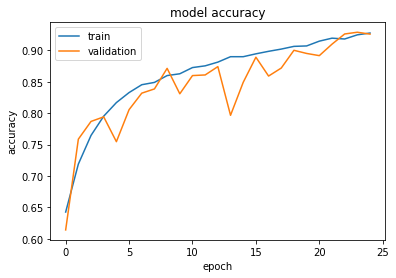

125/125 [==============================] - 0s 4ms/step - loss: 0.2100 - accuracy: 0.9165


In [40]:
 print(history.history)
 plt.plot(history.history['accuracy'])
 plt.plot(history.history['val_accuracy'])
 plt.title('model accuracy')
 plt.ylabel('accuracy')
 plt.xlabel('epoch')
 plt.legend(['train', 'validation'], loc='upper left')
 plt.show()

_ , t_acc = model.evaluate(x_test,y_test)


